#### Panagiotis Doupidis - 24/12/2021

### PCA

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn import metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(151)

In [22]:
# Load the Data
colnames = ["x" + str(i+1) for i in range(8)] + ["class"]
pulsar = pd.read_csv("HTRU_2.csv", index_col=False, names=[*colnames])

In [23]:
# Split to X, y 
X, y = pulsar.loc[:, :"x8"], pulsar["class"].to_numpy()

# Split the data to train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [24]:
# Scale data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### First, fit a Logistic Regression model 

In [25]:
clf = LogisticRegression(solver='lbfgs', verbose=1)
clf.fit(X_train, y_train)
print("Logistic Regression fit complete after %i iterations" % clf.n_iter_)

Logistic Regression fit complete after 34 iterations


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [26]:
# Make predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

In [27]:
# scoring and auc plot functions
def print_scores(test, pred):
    acc = metrics.accuracy_score(test, pred)
    prec = metrics.precision_score(test, pred)
    rec = metrics.recall_score(test, pred)
    f1 = metrics.f1_score(test, pred)
    print("Accuracy: %8.5f\nPrecision: %.5f\nRecall: %10.5f\nF1: %14.5f" %
          (acc, prec, rec, f1))


def plot_auc(test, pred_prob, plot_title = ""):
    fpr, tpr, _ = metrics.roc_curve(test,  pred_prob)
    auc = metrics.roc_auc_score(test, pred_prob)
    plt.figure(figsize=(8,6), dpi=100)
    plt.plot(fpr, tpr, label="AUC " + str(np.round(auc,8)), linewidth=1.5, color = "darkblue")
    plt.ylabel("True Positive Rate")
    plt.plot(plt.xlim(), plt.xlim(), linestyle='--',
             color='black', lw=1.4, scalex=False, scaley=False)
    plt.xlabel("False Positive Rate")
    plt.title(plot_title, loc= "center", fontweight="bold")
    plt.legend(loc=4)
    plt.show()


Accuracy:  0.97905
Precision: 0.93471
Recall:    0.82927
F1:        0.87884


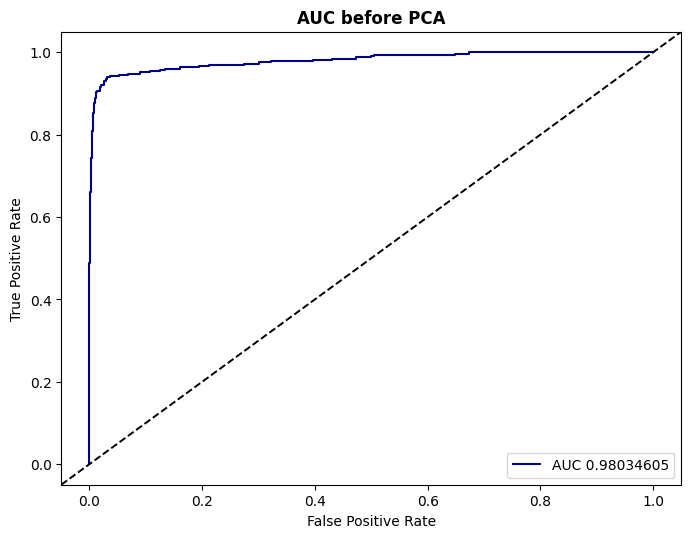

In [28]:
# show results for logistic regression model
print_scores(y_test, y_pred)
plot_auc(y_test, y_pred_prob, "AUC before PCA")

In [29]:
# Perform PCA w/ 4 componenets 
n_comp = 4
pca = PCA(n_components=n_comp, svd_solver="full")

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test) 

##### Perform the same process as before, train a Logistic Regression model, but in this instance use the lower dimension data

In [30]:
clf_pca = LogisticRegression(solver='lbfgs', verbose=1)

clf_pca.fit(X_train_pca, y_train)
print("Logistic Regression fit complete after %i iterations" % clf_pca.n_iter_)

Logistic Regression fit complete after 14 iterations


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [31]:
y_pred_pca = clf_pca.predict(X_test_pca)
y_pred_pca_prob = clf_pca.predict_proba(X_test_pca)[:,1]

Accuracy:  0.97402
Precision: 0.93358
Recall:    0.77134
F1:        0.84474


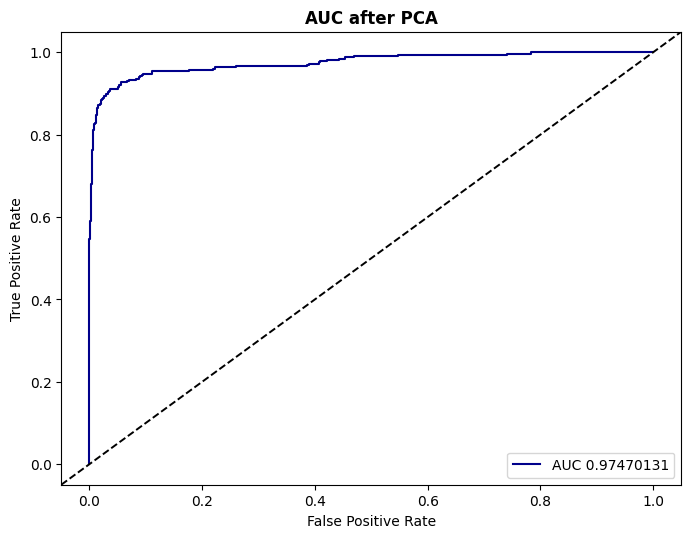

In [32]:
# evaluate PCA LR model
print_scores(y_test, y_pred_pca)
plot_auc(y_test, y_pred_pca_prob, "AUC after PCA")

#### AUC and evaluation metrics are very similar after reducing the number of dimension with PCA, so our model is simpler and also very accurate

#### 2. Scree plot to show the most important components

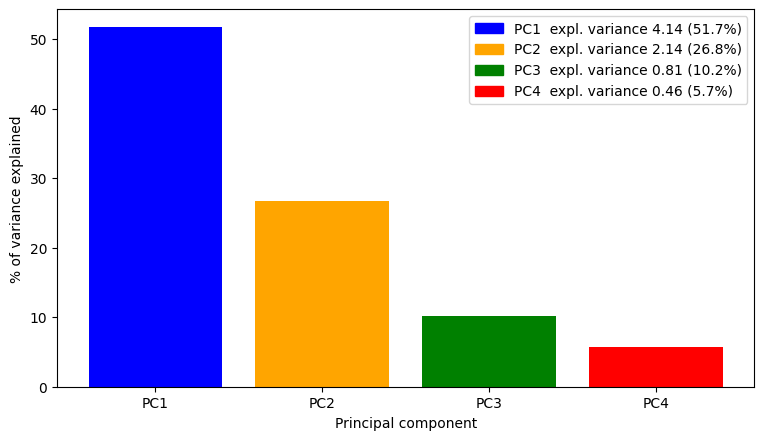

In [33]:
# list with the most important features and a plot

expl_var = pca.explained_variance_ratio_ * 100
colors = ["blue", "orange", "green", "red"]
labels = ["PC" + str(i+1) for i in range(n_comp)]
labels_plt = [labels[i] + "  expl. variance " + str(np.round(pca.explained_variance_[i], 2)) + " (" + str(np.round(var, 3)*100) + "%)" for i,
              var in enumerate(pca.explained_variance_ratio_)]

handles = [plt.Rectangle((0, 0), 1, 1, color=colors[idx])
           for idx, label in enumerate(labels)]

plt.figure(figsize=(9, 5), dpi=100)
plt.bar(x=range(1, n_comp+1), height=expl_var, color=colors)
plt.xticks(range(1, n_comp+1), labels=[*labels])
plt.ylabel("% of variance explained")
plt.xlabel("Principal component")
plt.legend(handles, labels_plt)
plt.show()


#### Compare 2 models

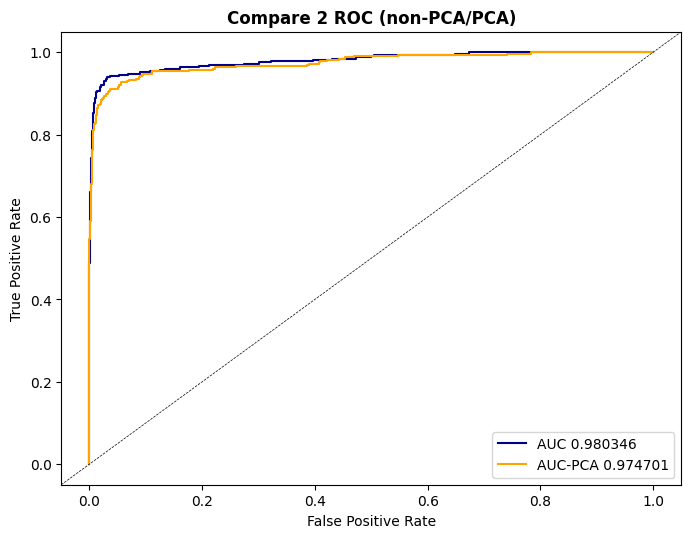

In [34]:
# plot both roc curves
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
fpr_pca, tpr_pca, _ = metrics.roc_curve(y_test,  y_pred_pca_prob)

auc = metrics.roc_auc_score(y_test, y_pred_prob)
auc_pca = metrics.roc_auc_score(y_test, y_pred_pca_prob)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(fpr, tpr, label="AUC " + str(np.round(auc,6)), linewidth=1.5, color="darkblue")
plt.plot(fpr_pca, tpr_pca, label="AUC-PCA " + str(np.round(auc_pca,6)), linewidth=1.5, color="orange")
plt.ylabel("True Positive Rate")
plt.plot(plt.xlim(), plt.xlim(), linestyle='--',
         color='black', lw=.5, scalex=False, scaley=False)
plt.xlabel("False Positive Rate")
plt.title("Compare 2 ROC (non-PCA/PCA)", loc="center", fontweight="bold")
plt.legend(loc=4)
plt.show()


#### Most important features in reverse order using SelectFPR

In [35]:
k_best_model = SelectKBest(score_func=mutual_info_classif, k="all")

X_train_best = k_best_model.fit_transform(X_train, y_train)
X_test_best = k_best_model.transform(X_test)

important_f_df = pd.DataFrame(sorted(list(zip(X.columns, k_best_model.scores_)), key=lambda x: x[1], reverse=True),
                 columns=["Feature", "Score"], index=np.arange(1, 9)).round(4).T


print("Most important features")
important_f_df.head(X_train.shape[1])

Most important features


,1,2,3,4,5,6,7,8
Feature,x3,x4,x1,x6,x8,x7,x5,x2
Score,0.2262,0.194,0.1924,0.1203,0.1148,0.1126,0.1125,0.0893


#### Compare PCA model(n=4) with the model with the 4 most important features above

In [36]:
# Keep only the 4 most important feautures, x3, x4, x1, x6
# First get the index of these features
imp_features_index = list(map(lambda x: int(x[0][1])-1, sorted(list(zip(X.columns, k_best_model.scores_)),
                                                               key=lambda x: x[1], reverse=True)))[:4]

X_train_nopca =  X_train[:,imp_features_index]
X_test_nopca = X_test[:, imp_features_index]

In [37]:
# Train LR
clf_nopca = LogisticRegression(solver='lbfgs', verbose=1)

clf_nopca.fit(X_train_nopca, y_train)
print("Logistic Regression fit complete after %i iterations" % clf_nopca.n_iter_)


Logistic Regression fit complete after 19 iterations


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [38]:
# Make predictions based on the new model
y_pred_nopca = clf_nopca.predict(X_test_nopca)
y_pred_nopca_prob = clf_nopca.predict_proba(X_test_nopca)[:,1]

Accuracy:  0.97598
Precision: 0.92908
Recall:    0.79878
F1:        0.85902


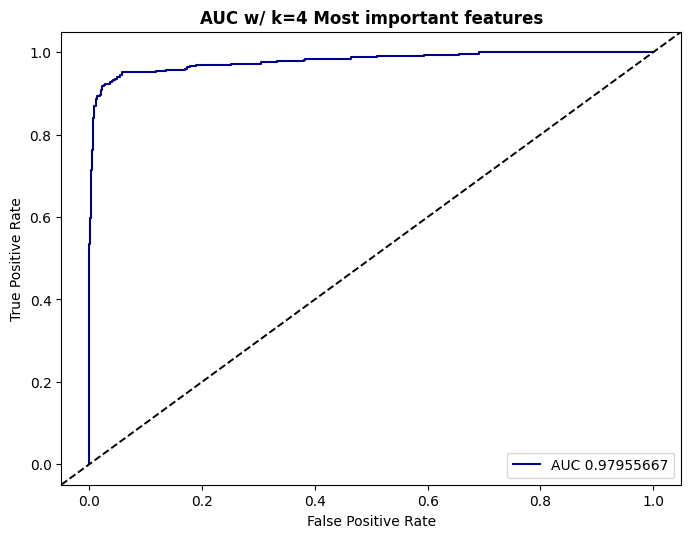

In [39]:
# Evaluate model with k=4 most important features
print_scores(y_test, y_pred_nopca)
plot_auc(y_test, y_pred_nopca_prob, "AUC w/ k=4 Most important features")


#### Compare PCA model with the best model with 4 features

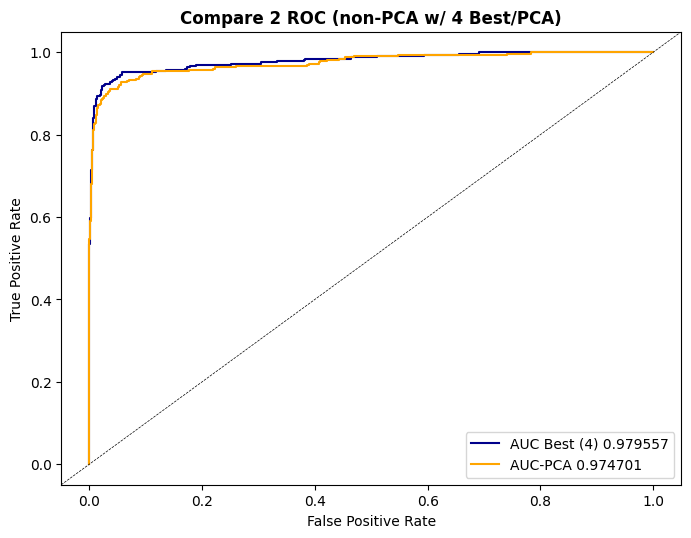

In [40]:
fpr_nopca, tpr_nopca, _ = metrics.roc_curve(y_test,  y_pred_nopca_prob)
fpr_pca, tpr_pca, _ = metrics.roc_curve(y_test,  y_pred_pca_prob)

auc_nopca = metrics.roc_auc_score(y_test, y_pred_nopca_prob)
auc_pca = metrics.roc_auc_score(y_test, y_pred_pca_prob)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(fpr_nopca, tpr_nopca, label="AUC Best (4) " + str(np.round(auc_nopca, 6)),
         linewidth=1.5, color="darkblue")
plt.plot(fpr_pca, tpr_pca, label="AUC-PCA " +
         str(np.round(auc_pca, 6)), linewidth=1.5, color="orange")
plt.ylabel("True Positive Rate")
plt.plot(plt.xlim(), plt.xlim(), linestyle='--',
         color='black', lw=.5, scalex=False, scaley=False)
plt.xlabel("False Positive Rate")
plt.title("Compare 2 ROC (non-PCA w/ 4 Best/PCA)", loc="center", fontweight="bold")
plt.legend(loc=4)
plt.show()
